In [1]:
%load_ext autoreload
%autoreload 2

from cobolt.utils import SingleData, MultiomicDataset
from cobolt.model import Cobolt
import os
import gc
import numpy as np
import pandas as pd
import scipy.sparse as sps
import scanpy as sc
import scipy.io as sio

from os.path import join
import matplotlib.pyplot as plt

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/tqdm-4.65.0-py3.8.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/umap_learn-0.5.3-py3.8.egg/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/umap_learn-0.5.3-py3.8.egg/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' 

In [2]:
# Path to the data directory
data_dir = "/home/sda1/yanxh/data/DOGMA"

## Read Data

In [3]:
print('Reading `mtx` files...')
cite_rna_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'CITE-seq/rna_mat_count.mtx')).T)
cite_adt_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'CITE-seq/adt_mat_count.mtx')).T)
asap_atac_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'ASAP-seq/atac_mat_count.mtx')).T)
asap_adt_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'ASAP-seq/adt_mat_count.mtx')).T)

cite_cell_names = pd.read_csv(join(data_dir, 'CITE-seq/cell_names.csv'))['x'].to_numpy()
asap_cell_names = pd.read_csv(join(data_dir, 'ASAP-seq/cell_names.csv'))['x'].to_numpy()

cite_rna_names = pd.read_csv(join(data_dir, 'CITE-seq/hvg_names.csv'))['VariableFeatures(CITE_rna)'].to_numpy()
cite_adt_names = pd.read_csv(join(data_dir, 'CITE-seq/adt_names.csv'))['VariableFeatures(CITE_ASAP_adt)'].to_numpy()
asap_atac_names = pd.read_csv(join(data_dir, 'ASAP-seq/hvp_names.csv'))['VariableFeatures(ASAP_atac)'].to_numpy()
asap_adt_names = pd.read_csv(join(data_dir, 'ASAP-seq/adt_names.csv'))['VariableFeatures(CITE_ASAP_adt)'].to_numpy()

cite_meta_data = pd.read_csv(join(data_dir, 'CITE-seq/metadata.csv'), index_col=0)
asap_meta_data = pd.read_csv(join(data_dir, 'ASAP-seq/metadata.csv'), index_col=0)

cite_rna_mat.shape, cite_adt_mat.shape, asap_atac_mat.shape, asap_adt_mat.shape

Reading `mtx` files...


((8689, 2000), (8689, 227), (8535, 51816), (8535, 227))

Alternatively, a `SingleData` object can also be constructed using a processed
scipy sparse matrix of counts and string arrays of feature and barcode names.
We show an example below for reading the mRNA data from sparse matrix.

In [4]:
cite_rna = SingleData("GeneExpr", "CITE", cite_rna_names, cite_rna_mat, cite_cell_names)
cite_adt = SingleData("ADT", "CITE", cite_adt_names, cite_adt_mat, cite_cell_names)

In [5]:
asap_adt = SingleData("ADT", "ASAP", asap_adt_names, asap_adt_mat, asap_cell_names)
asap_atac = SingleData("ATAC", "ASAP", asap_atac_names, asap_atac_mat, asap_cell_names)

Merge the above three datasets. Cells with the identical barcode names and
dataset names are recognized as joint cells. Cobolt focus on common features
shared across datasets. Genes are subset to those detected by both SNARE-seq
and scRNA-seq. We also performed preprocessing that mapped the SNARE-seq
chromatin accessibility counts to peaks called on the scATAC-seq dataset, such
that they share the same feature set. A batch variable is
automatically added when merging datasets. Different datasets are treated as
different batches.

In [6]:
multi_dt = MultiomicDataset.from_singledata(
    cite_rna, cite_adt, asap_adt, asap_atac
)
print(multi_dt)

A MultiomicDataset object with 3 omics:
- GeneExpr: 2000 features, 8689 cells, 1 batches.
- ADT: 227 features, 17224 cells, 2 batches.
- ATAC: 51816 features, 8535 cells, 1 batches.
Joint cells:
- ADT, ATAC: 8535 cells.
- GeneExpr, ATAC: 0 cells.
- GeneExpr, ADT: 8689 cells.
- GeneExpr, ADT, ATAC: 0 cells.


## Training

We now train the Cobolt model with the number of latent variables set to 10. We
use a small iteration in this vignette for illustration purpose. The default
number of iteration is set to 100.

In [7]:
model = Cobolt(dataset=multi_dt, lr=0.001, n_latent=10, batch_size=128) 
model.train(num_epochs=100)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [25:21<00:00, 15.22s/it]


Calculate the corrected latent variables.

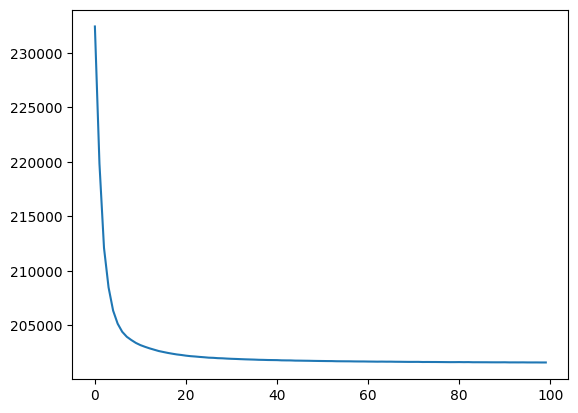

In [8]:
plt.plot(model.history['loss'])

In [9]:
model.calc_all_latent(target=[True, True, False])  # default [T, T, T], cause bug

latent = model.get_all_latent()

# latent_raw = model.get_all_latent(correction=False)

### Evaluation

In [7]:
def get_umap(adata, use_rep='X_emb_shr', add_key=None):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    
    add_key = 'X_umap' if add_key is None else add_key
    adata.obsm[add_key] = adata.obsm['X_umap']
    return adata

In [8]:
if False:
    latent_barcode = np.array([_.split('~')[1] for _ in latent[1]])
    df_latent = pd.DataFrame(latent[0], index=latent_barcode)
    df_latent.to_csv('./outputs/cite-asap.csv')

else:
    df_latent = pd.read_csv('./outputs/cite-asap.csv', index_col=0)

In [9]:
ad_cite = sc.AnnData(cite_rna_mat, obs=cite_meta_data)
ad_cite.obs_names = cite_cell_names

ad_asap = sc.AnnData(asap_adt_mat, obs=asap_meta_data)
ad_asap.obs_names = asap_cell_names

In [10]:
ad_cite.obs.celltypes.unique()

array(['NK', 'CD4 T', 'B', 'CD8 T', 'Mono', 'DC'], dtype=object)

In [11]:
ad_cite.obsm['X_emb'] = df_latent.loc[ad_cite.obs_names, :].values
ad_asap.obsm['X_emb'] = df_latent.loc[ad_asap.obs_names, :].values

ad_cite.obs['mod'] = 'cite'
ad_asap.obs['mod'] = 'asap'
ad_cite.obs['mod-batch'] = (ad_cite.obs['mod'] + '-' + ad_cite.obs.batch).to_numpy()
ad_asap.obs['mod-batch'] = (ad_asap.obs['mod'] + '-' + ad_asap.obs.batch).to_numpy()

ad_cite.obs['celltypes_false'] = ad_cite.obs.celltypes.to_numpy()
ad_asap.obs['celltypes_false'] = ad_asap.obs.celltypes.to_numpy()

type2dict = {'NK':'NK', 'CD4 T': 'T cell', 'CD8 T': 'T cell', 'B': 'B cell', 'Mono': 'Myeloid', 'DC': 'Myeloid'}
ad_cite.obs['celltypes'] = [type2dict[_] for _ in ad_cite.obs.celltypes]
ad_asap.obs['celltypes'] = [type2dict[_] for _ in ad_asap.obs.celltypes]

In [15]:
ad_cite = get_umap(ad_cite, use_rep='X_emb')
# ad_asap = get_umap(ad_asap, use_rep='X_emb')
# atac_test = get_umap(atac_test, use_rep='X_emb')

In [25]:
# sc.pl.umap(ad_cite, color=['celltypes', 'batch'])

In [12]:
import sys
sys.path.insert(0, '/home/yanxh/gitrepo/multi-omics-matching/ACE/reproduce/evaluation')

from evaluation import eval_mosaic, eval_specific_mod, eval_bridge, print_results, eval_asw, eval_lisi, eval_clustering
# from evaluation import eval_bridge_above2

### (1) Mosaic eval

### 1.1 without harmony

In [16]:
ad_mosaic = sc.concat([ad_cite, ad_asap])

r = eval_mosaic(ad_mosaic, label_key='celltypes', lisi_keys=['mod-batch', 'mod'], use_rep='X_emb',
               use_gc=False, use_nmi=False)

mod-batch_LISI=0.28478
mod_LISI=0.74196


In [17]:
nmi, ari = eval_clustering(
    ad_mosaic, label_key='celltypes', cluster_key='cluster', resolutions=None, use_rep='X_emb',
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.4742085225019715, 0.21240986566380343)

### 1.2 with harmony

In [13]:
from preprocessing import harmony

In [19]:
ad_mosaic = sc.concat([ad_cite, ad_asap])

ad_mosaic_df = pd.DataFrame(ad_mosaic.obsm['X_emb'], index=ad_mosaic.obs_names)
ad_mosaic_df['batch'] = ad_mosaic.obs['mod-batch'].to_numpy()
ad_mosaic.obsm['X_emb_harmony'] = harmony([ad_mosaic_df])[0]

r = eval_mosaic(ad_mosaic, label_key='celltypes', lisi_keys=['mod-batch', 'mod'], use_rep='X_emb_harmony',
               use_gc=False, use_nmi=False)

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).
mod-batch_LISI=0.64168
mod_LISI=0.89278


In [20]:
nmi, ari = eval_clustering(
    ad_mosaic, label_key='celltypes', cluster_key='cluster', resolutions=None, use_rep='X_emb_harmony',
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.6057766093537437, 0.4538248098199171)

## Clustering and Visualization

In [14]:
umap_save_dir = '/home/sda1/yanxh/outputs/umap_plots'

In [18]:
def get_umap(adata, use_rep='X_emb_shr', add_key=None):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    
    add_key = 'X_umap' if add_key is None else add_key
    adata.obsm[add_key] = adata.obsm['X_umap']
    return adata

def save_umap(adata, use_rep, colors, is_title='', legend_loc=None, save_dir=None, prefix_name=None):
    for c in colors:
        sc.pl.embedding(adata, basis=use_rep, color=[c], legend_fontsize=4, legend_loc=legend_loc,
              frameon=False, legend_fontoutline=2, show=False, title=is_title) # cmap=reds, vmin=0.00001, 
        plt.savefig(f"{save_dir}/{prefix_name}_{c}_legend={legend_loc}.jpg", bbox_inches="tight", dpi=300)

In [16]:
ad_mosaic = sc.concat([ad_cite, ad_asap])
ad_mosaic = get_umap(ad_mosaic, use_rep='X_emb', add_key='X_umap_1')

ad_mosaic_df = pd.DataFrame(ad_mosaic.obsm['X_emb'], index=ad_mosaic.obs_names)
ad_mosaic_df['batch'] = ad_mosaic.obs['mod-batch'].to_numpy()
ad_mosaic.obsm['X_emb_harmony'] = harmony([ad_mosaic_df])[0]
ad_mosaic = get_umap(ad_mosaic, use_rep='X_emb_harmony', add_key='X_harmony_umap')

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).


/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax

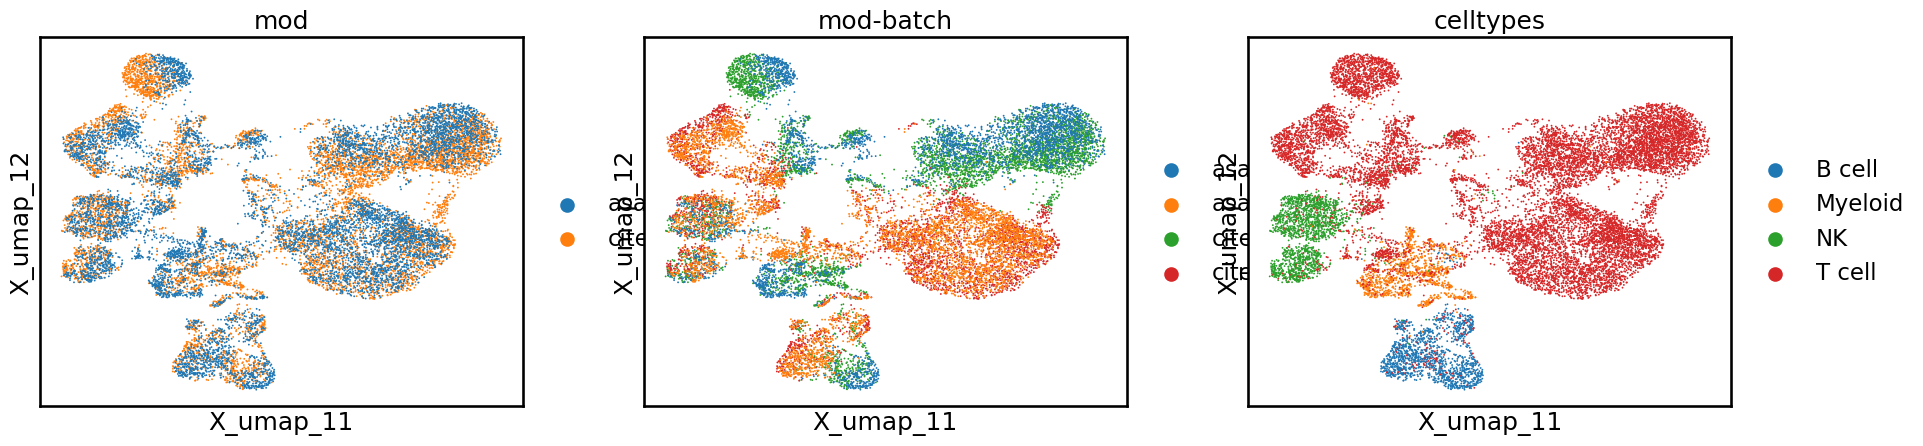

In [19]:
sc.pl.embedding(ad_mosaic, basis='X_umap_1', color=['mod', 'mod-batch', 'celltypes'], legend_loc='right margin')

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax

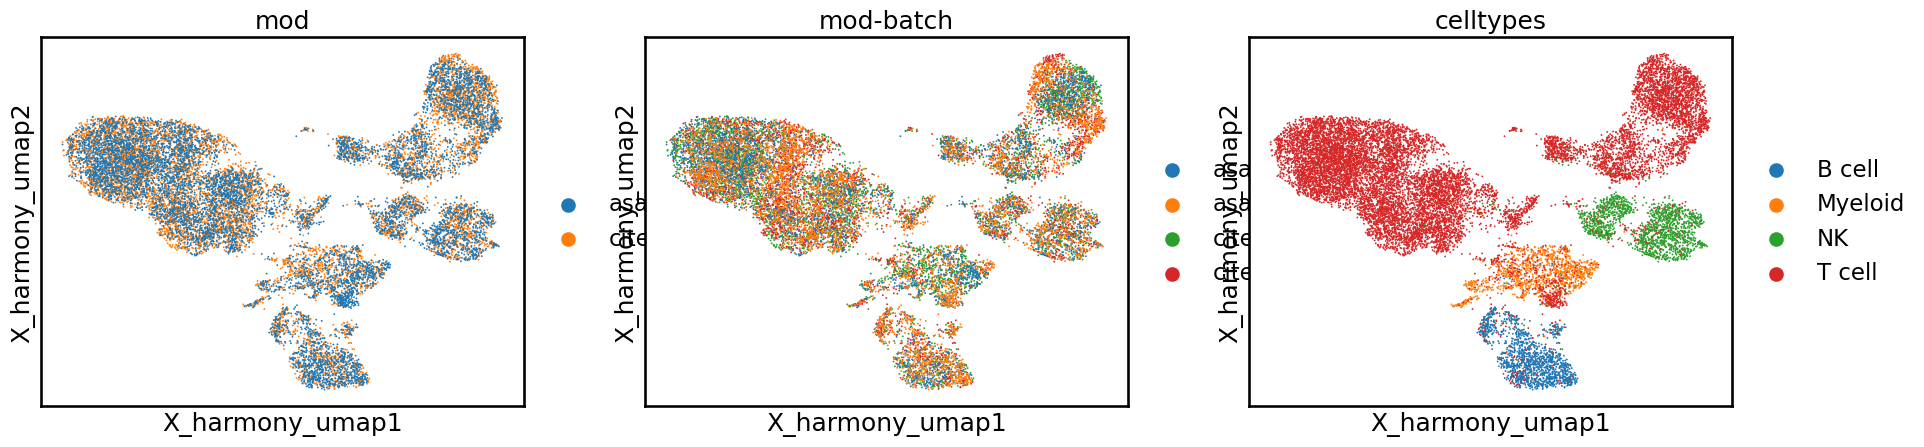

In [20]:
sc.pl.embedding(ad_mosaic, basis='X_harmony_umap', color=['mod', 'mod-batch', 'celltypes'], legend_loc='right margin')

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages

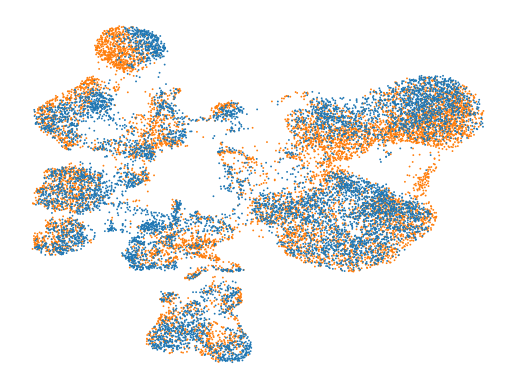

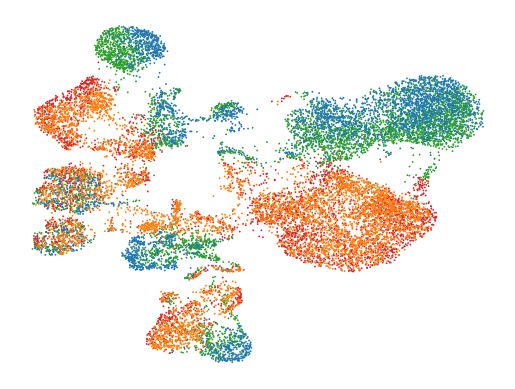

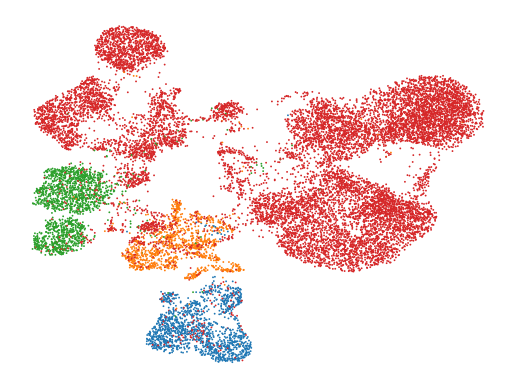

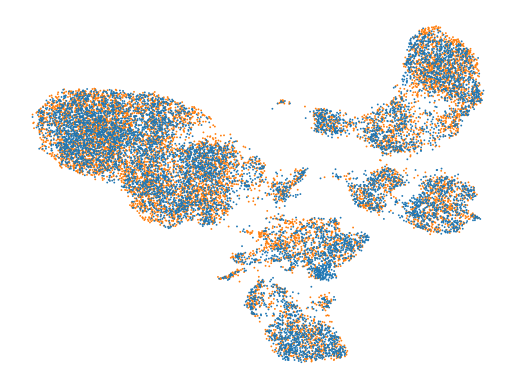

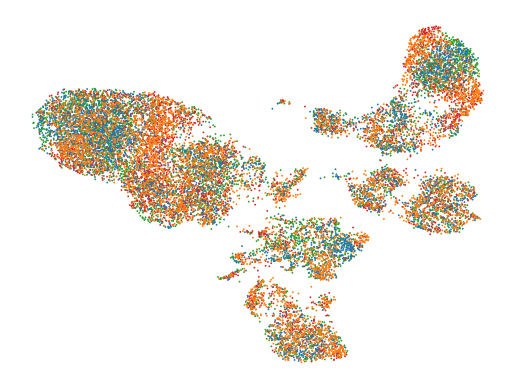

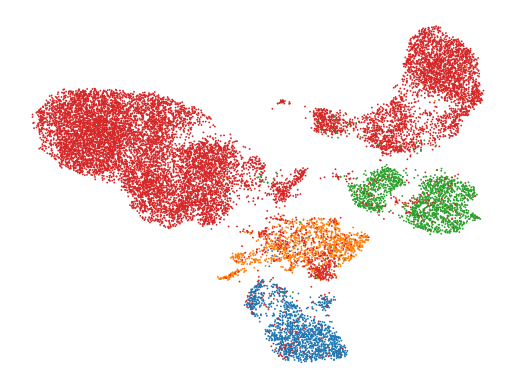

In [21]:
save_umap(ad_mosaic, 'X_umap_1', ['mod', 'mod-batch', 'celltypes'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec2/umap', 
          prefix_name='cobolt_case2_CITE-ASAP')

save_umap(ad_mosaic, 'X_harmony_umap', ['mod', 'mod-batch', 'celltypes'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec2/umap', 
          prefix_name='cobolt-harmony_case2_CITE-ASAP')

In [22]:
np.save(join(umap_save_dir, 'cobolt_case2_CITE-ASAP_umap.npy'), ad_mosaic.obsm['X_umap_1'])
np.save(join(umap_save_dir, 'cobolt-harmony_case2_CITE-ASAP_umap.npy'), ad_mosaic.obsm['X_harmony_umap'])